In [1]:
#%pip install openpyxl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error
import random
import scipy
import glob
import os

labels = ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAB',  
    'kAN',  
    'kAOH', 
    'kNH']

# Importando experimentos

In [2]:
def import_dfs():
    # Path to the folder containing CSV files
    folder_path = '../dados/'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    # Initialize an empty list to hold dataframes
    data_frames = []

    # Read the first CSV file to establish the schema
    schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm','apa_t']


    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  
        print(file)
        df = df[schema]  # Reorder columns to match the schema
        data_frames.append(df)
    
    csv_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]
    return data_frames,csv_files 
data_frames_exp,file_list_exp = import_dfs()
x_names = list(data_frames_exp[0].columns[:-1])
print(file_list_exp)
print(x_names)

../dados\25.45nh60ab20.csv
../dados\25.46nh30ab30.csv
../dados\25.47nh5ab80.csv
../dados\5.100nh40ab80.csv
../dados\5.102nh20ab40.csv
../dados\5.103nh40ab30.csv
../dados\5.106nh100ab40.csv
../dados\5.107nh55ab55.csv
../dados\5.109nh5ab55.csv
../dados\5.110nh10ab55.csv
../dados\5.112nh78ab35.csv
../dados\5.48nh20ab80.csv
../dados\5.80nh12ab40.csv
../dados\5.81nh5ab30.csv
../dados\nh60ab80.csv
['25.45nh60ab20', '25.46nh30ab30', '25.47nh5ab80', '5.100nh40ab80', '5.102nh20ab40', '5.103nh40ab30', '5.106nh100ab40', '5.107nh55ab55', '5.109nh5ab55', '5.110nh10ab55', '5.112nh78ab35', '5.48nh20ab80', '5.80nh12ab40', '5.81nh5ab30', 'nh60ab80']
['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']


# Definindo modelo

In [3]:
def enzymic_amox(t,y, 
kcat1,
kcat2,
Km1,
Km2,  
Tmax, 
Ken,  
kAB,  
kAN,  
kAOH, 
kNH):
    FAB = 0
    FNH = 0 
    
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    Cez = 1

    # Consumo de ester
    VAB = (kcat1*CAB*Cez)/((Km1*(1 + (CAN/kAN) + (CAOH/kAOH))) + CAB)
    
    # Hidrolise de amoxicilina
    VAN = (kcat2*CAN*Cez)/((Km2*(1 + (CAB/kAB) + (CNH/kNH) + (CAOH/kAOH))) + CAN)
    
    # Enzima saturada com 6-apa
    X   = CNH/(Ken + CNH)
    
    # Sintese enzimatica
    VS  = VAB*Tmax*X

    # Hidrolise de ester
    Vh1 = (VAB - VS) 

    dy = np.zeros(4)

    # C. ester
    dy[0] = ((-(VS - VAN) - (Vh1 + VAN)) + FAB) 
    
    # C. amox
    dy[1] = (VS - VAN)                         
    
    # C. 6-apa
    dy[2] = (-(VS - VAN) + FNH)                
    
    # C. POHPG
    dy[3] =  (Vh1 + VAN)
    
    return np.array(dy)      

In [4]:
def ode15s_amox(P, CI, t):
    return scipy.integrate.solve_ivp(enzymic_amox,t_span=(t[0],t[-1]),t_eval=t,y0=CI,method='BDF',args=P).y.T

# Parâmetros estimados c/ 50000 cadeias

In [5]:
def import_dfs():
    # Path to the folder containing CSV files
    folder_path = './results_mcmc'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '50000*mean.csv'))
    
    # Initialize an empty list to hold dataframes
    data_frames = []

    # Read the first CSV file to establish the schema
    schema = ['kcat1',
        'kcat2',
        'Km1',
        'Km2',  
        'Tmax', 
        'Ken',  
        'kAB',  
        'kAN',  
        'kAOH', 
        'kNH']


    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  
        
        df = df[schema]  # Reorder columns to match the schema
        data_frames.append(df)
    
    csv_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]
    print(csv_files)
    return data_frames,csv_files 

data_frames_chains,file_list = import_dfs()

['50000_article_mean', '50000_bestnm_mean', '50000_lucas_mean', '50000_luci_mean']


In [6]:
'''par_sum = np.zeros((10))
for df in data_frames_chains:
    fig,ax = plt.subplots(2,5,figsize=[20,8])
    ax = ax.flatten()
    labels = ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAB',  
    'kAN',  
    'kAOH', 
    'kNH']
    cursum = np.zeros((10))
    for idx,par in enumerate(labels):
        cursum[idx] = df[par].sum()
        ax[idx].plot(df[par])    
        ax[idx].set_title(par)
        ax[idx].set_ylabel("Value")
        ax[idx].set_xlabel("Initial conditions")
    par_sum += cursum'''

'par_sum = np.zeros((10))\nfor df in data_frames_chains:\n    fig,ax = plt.subplots(2,5,figsize=[20,8])\n    ax = ax.flatten()\n    labels = [\'kcat1\',\n    \'kcat2\',\n    \'Km1\',\n    \'Km2\',  \n    \'Tmax\', \n    \'Ken\',  \n    \'kAB\',  \n    \'kAN\',  \n    \'kAOH\', \n    \'kNH\']\n    cursum = np.zeros((10))\n    for idx,par in enumerate(labels):\n        cursum[idx] = df[par].sum()\n        ax[idx].plot(df[par])    \n        ax[idx].set_title(par)\n        ax[idx].set_ylabel("Value")\n        ax[idx].set_xlabel("Initial conditions")\n    par_sum += cursum'

## Guardar ensaios em um dataframe

In [7]:
ensaios_dfs = []
for i in range(data_frames_chains[0].shape[0]):
    ensaios_dfs.append(pd.DataFrame(data=np.zeros((len(data_frames_chains),data_frames_chains[0].shape[1])),index=file_list,columns=labels))

for idx,df in enumerate(data_frames_chains):
    for row in df.index:
        ensaios_dfs[row].loc[file_list[idx],:] = df.iloc[row]

### Desvios padrões

In [22]:
all_std = np.zeros(10)

for df in ensaios_dfs:
    for idx,par in enumerate(labels):
        all_std[idx] += df.std(ddof=0).loc[par]

all_std = all_std/len(ensaios_dfs)
print('Desvio padrão dos valores de parâmetros - média de cada apriori')
for idx,par in enumerate(labels):
    print(par,all_std[idx]/len(all_std))

Desvio padrão dos valores de parâmetros - média de cada apriori
kcat1 0.0029254216038783133
kcat2 0.07043531107546613
Km1 0.1788485514430211
Km2 0.5491062965050639
Tmax 0.016895419364824478
Ken 0.4156091034168183
kAB 48.21727767144574
kAN 0.13969555963642388
kAOH 0.497457449275059
kNH 71.80971651940821


## Visualização da performance

In [9]:
def model_eval(x_model, t_model, val_x, val_t):
    fig, axis = plt.subplots(2, 2, figsize=[6, 6])
    labels = ['POH-PGME','Amoxicillin','6-APA','POHPG']
    mlabels = ['POH-PGME model','Amoxicillin model','6-APA model','POHPG model']
    style = ['.r','.g','.b','.k']
    mstyle = ['-ok','-ok','-ok','-ok']    
    for idx,ax in enumerate(axis.flatten()):
        ax.plot(val_t, val_x[:, idx], style[idx], label=labels[idx],linewidth=0.5,markersize=5)
        ax.plot(t_model, x_model[:, idx], mstyle[idx], label=mlabels[idx],linewidth=0.9,markersize=3)
        ax.set_title(f'{labels[idx]}')
        ax.set_ylim([val_x[:, idx].min()-5, val_x[:, idx].max()+5])
        ax.set_xlim([0, val_t[-1]+5])
        ax.legend()

In [10]:
def eval_performance(P,plot=False):
    total_error = 0
    for exp_name,df_exp in zip(file_list_exp,data_frames_exp):
        x_target = df_exp.loc[:,x_names].to_numpy()
        t_target = df_exp['apa_t'].to_numpy()
        
        ic = x_target[0]
        t_model = np.linspace(t_target[0],t_target[-1],len(t_target))
        
        sol_val = ode15s_amox(P,ic,t_target)
        x_model = sol_val
        error = root_mean_squared_error(x_target, sol_val)

        total_error += error
        if plot:
            print(f'Error {exp_name}: {error}')
        
            model_eval(x_model,t_target,x_target,t_target)
    if plot:
        print('total error: ',total_error)
    return total_error

In [11]:
eval_performance(ensaios_dfs[0].iloc[0,:].to_numpy())

107.26114816195053

## Avaliar os parâmetros universalmente

In [12]:
import seaborn as sns
def find_best():
    grid = pd.DataFrame(np.zeros((ensaios_dfs[0].shape[0],len(ensaios_dfs))),index=ensaios_dfs[0].index,columns=file_list_exp)
    for df,name in zip(ensaios_dfs,file_list_exp):
        for row in df.index:
            P = df.loc[row,:].to_numpy()
            error = eval_performance(P)/len(ensaios_dfs)
            grid.loc[row,name] = error
    return grid
best = find_best()

<Axes: >

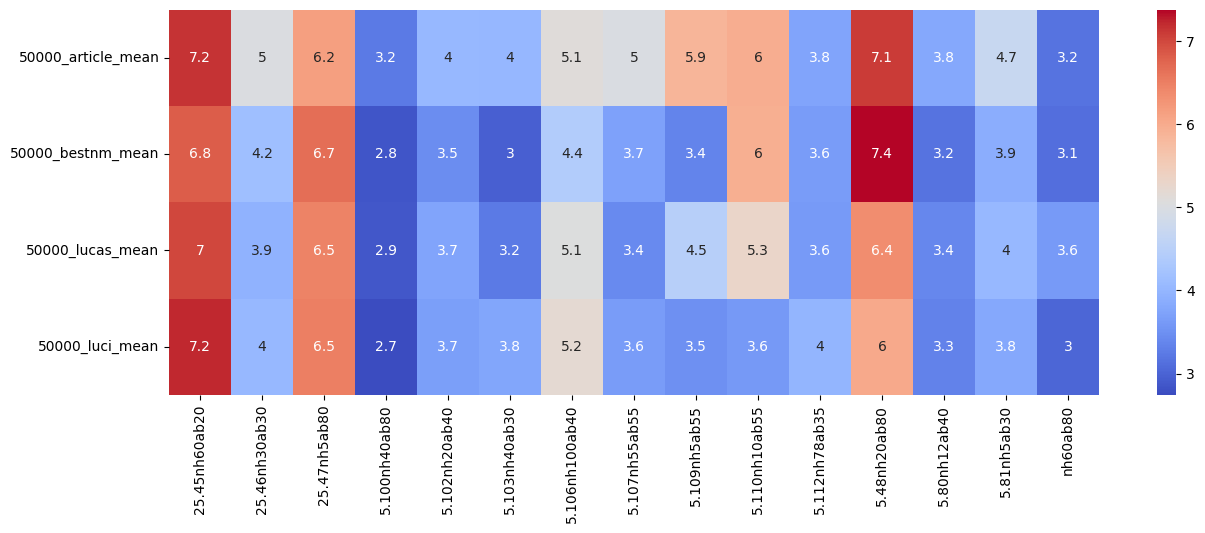

In [13]:
plt.figure(figsize=(15,5))
sns.heatmap(best,annot=True, cmap='coolwarm')

Error 25.45nh60ab20: 6.206241027203255
Error 25.46nh30ab30: 5.400422516875789
Error 25.47nh5ab80: 5.355347249689251
Error 5.100nh40ab80: 1.0984265304820096
Error 5.102nh20ab40: 2.0214347454703008
Error 5.103nh40ab30: 1.3997497257189684
Error 5.106nh100ab40: 3.895570443633695
Error 5.107nh55ab55: 0.6573303863563763
Error 5.109nh5ab55: 1.2733865063605987
Error 5.110nh10ab55: 0.5518196983352142
Error 5.112nh78ab35: 3.337991113619994
Error 5.48nh20ab80: 2.5166559158774917
Error 5.80nh12ab40: 2.57305523640026
Error 5.81nh5ab30: 1.9349471206722717
Error nh60ab80: 4.325727723622502
total error:  42.548105940317974


42.548105940317974

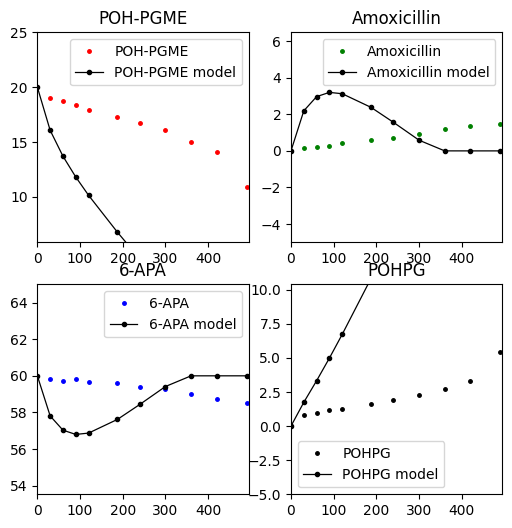

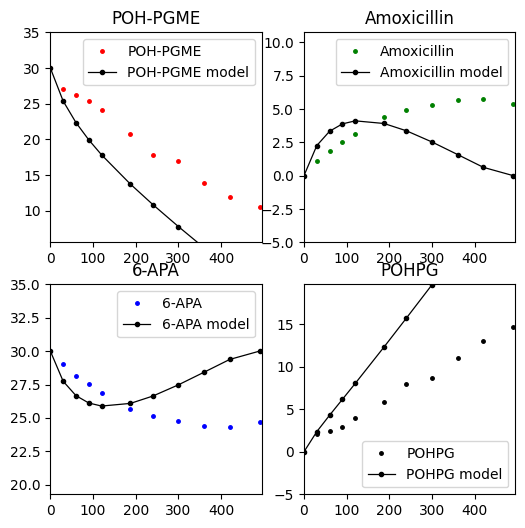

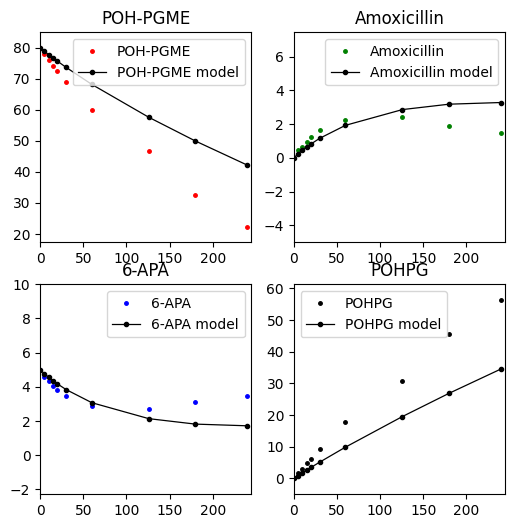

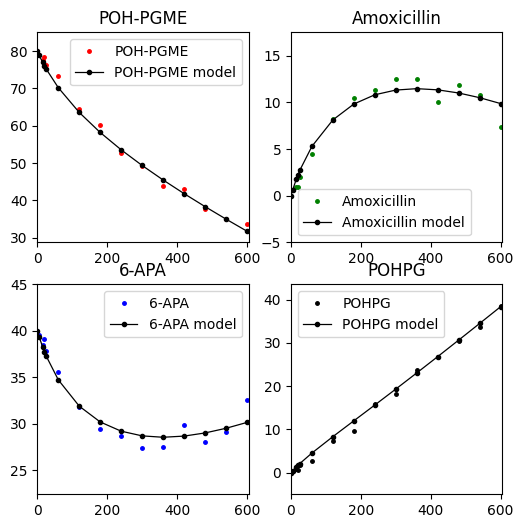

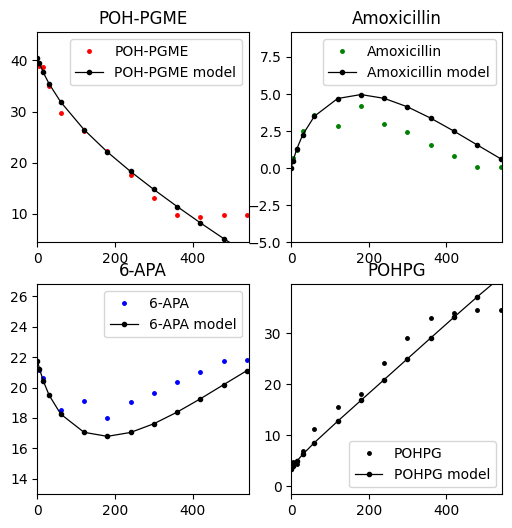

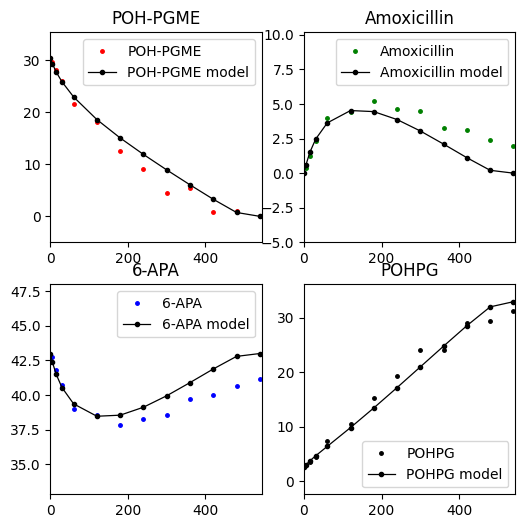

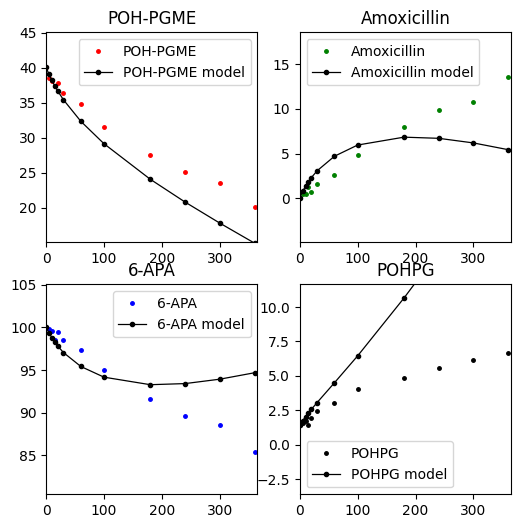

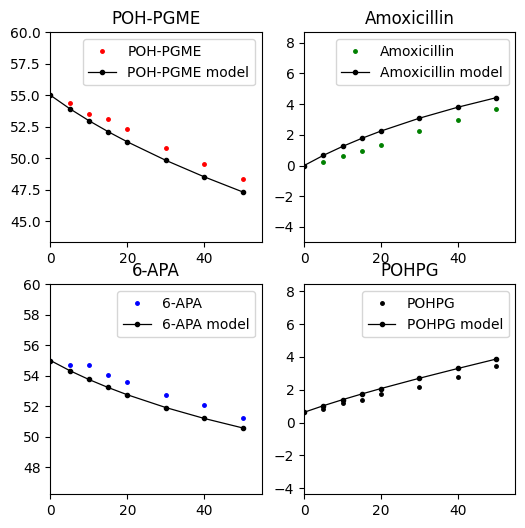

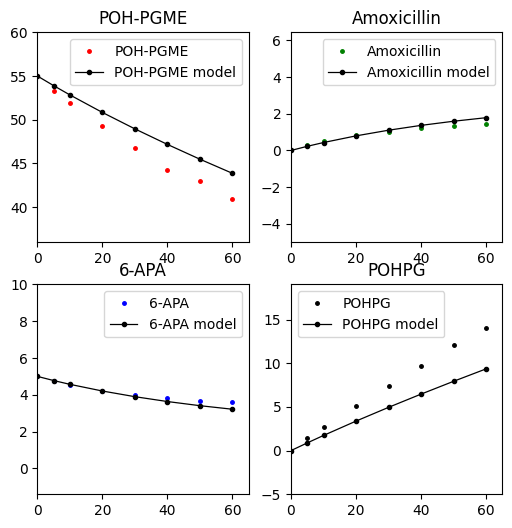

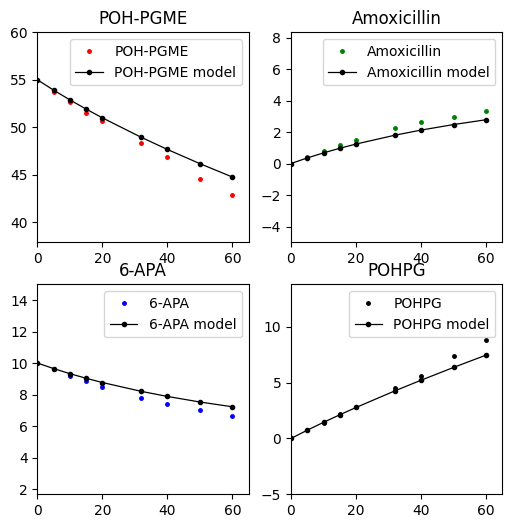

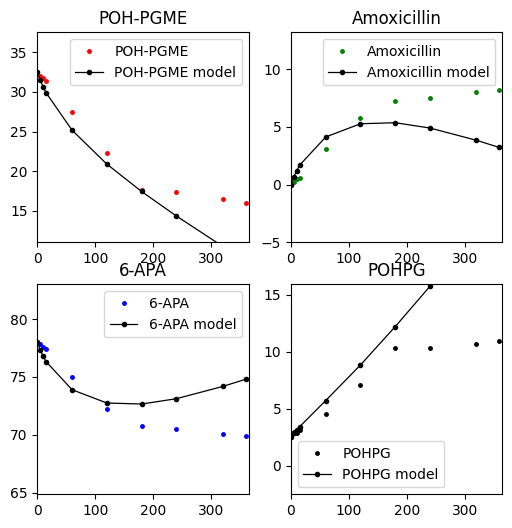

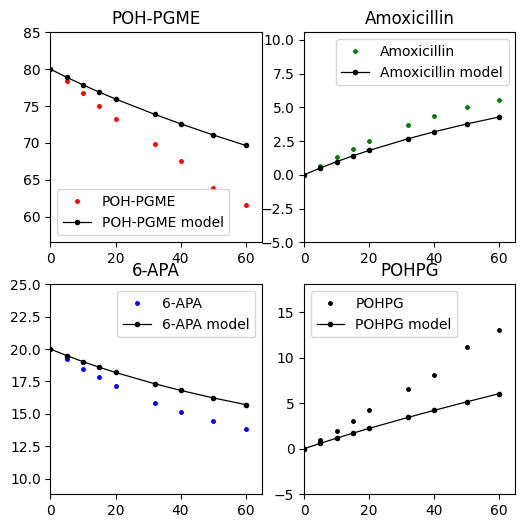

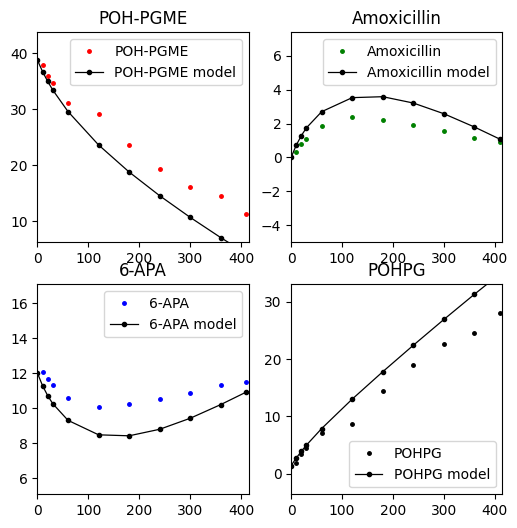

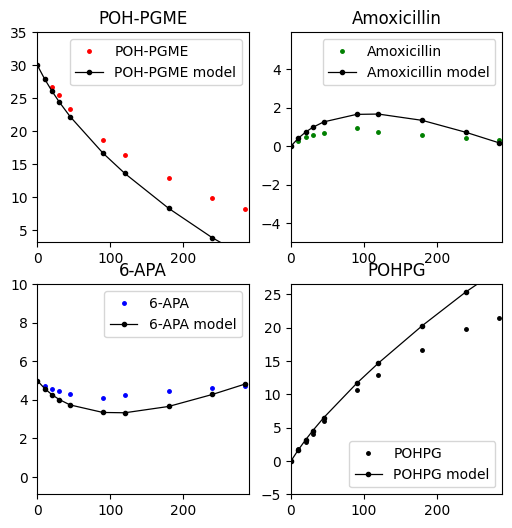

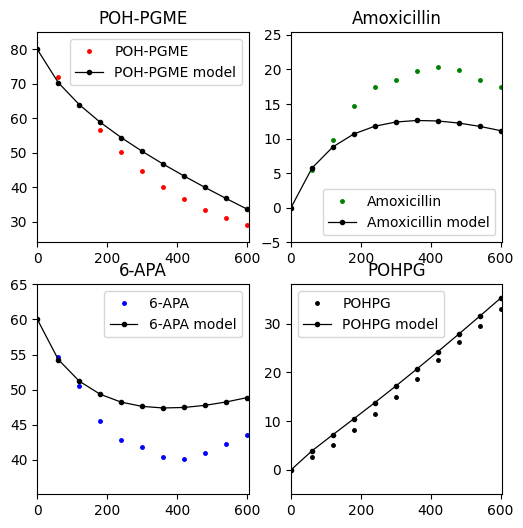

In [14]:
eval_performance(ensaios_dfs[3].loc['50000_bestnm_mean',:],plot=True)

Error 25.45nh60ab20: 4.9699139103986125
Error 25.46nh30ab30: 3.5858461213463837
Error 25.47nh5ab80: 7.969638029135394
Error 5.100nh40ab80: 0.9322616287772358
Error 5.102nh20ab40: 2.646185181602805
Error 5.103nh40ab30: 2.2596262753767937
Error 5.106nh100ab40: 2.8487264913369437
Error 5.107nh55ab55: 0.538985945454884
Error 5.109nh5ab55: 2.5001165566824444
Error 5.110nh10ab55: 1.6995025026181256
Error 5.112nh78ab35: 2.0896267854678134
Error 5.48nh20ab80: 3.5702104341259915
Error 5.80nh12ab40: 0.7438078931570615
Error 5.81nh5ab30: 1.3104554039976146
Error nh60ab80: 3.5064901464164415
total error:  41.17139330589454


41.17139330589454

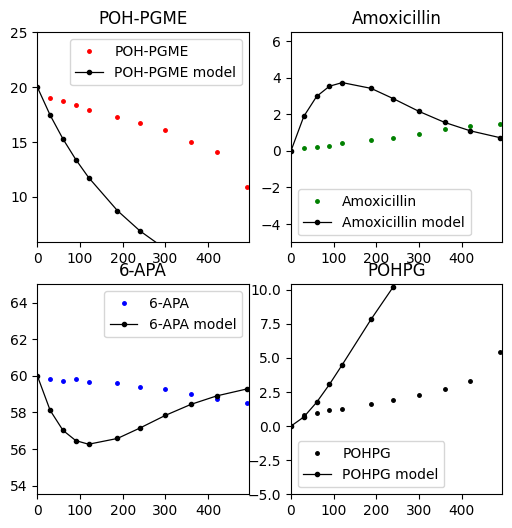

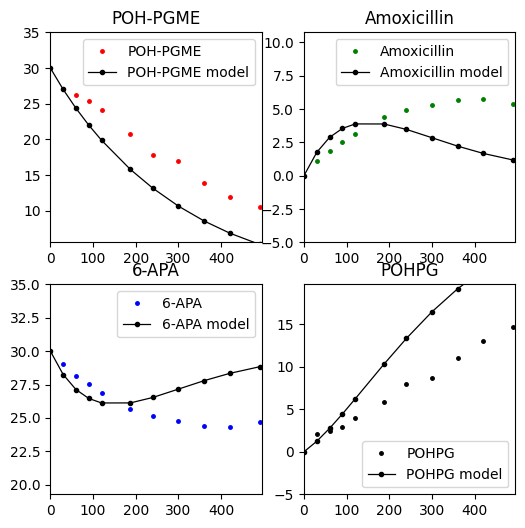

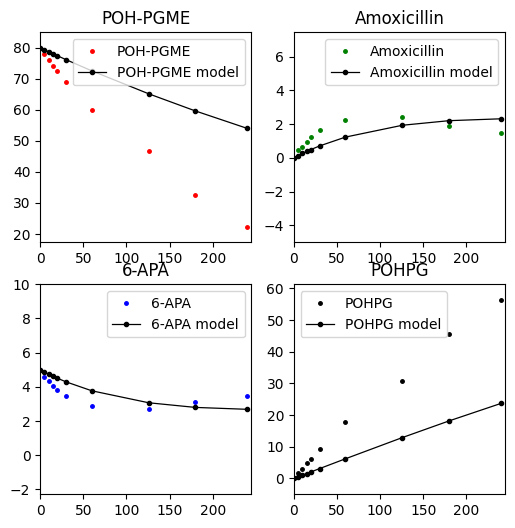

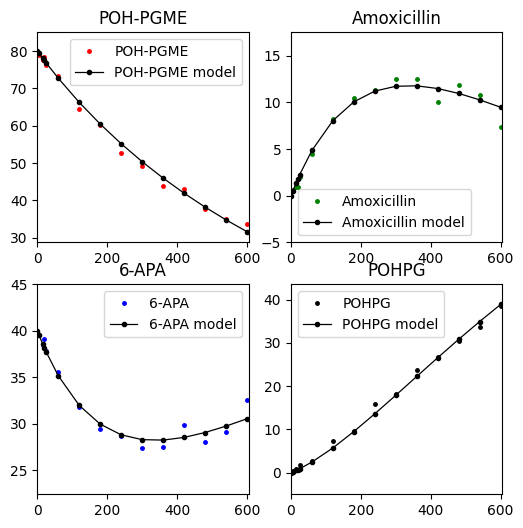

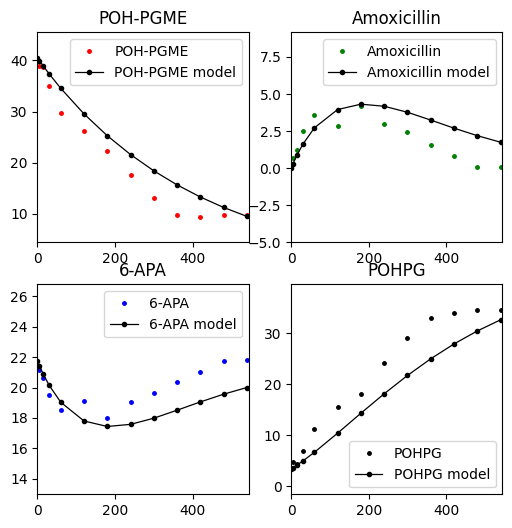

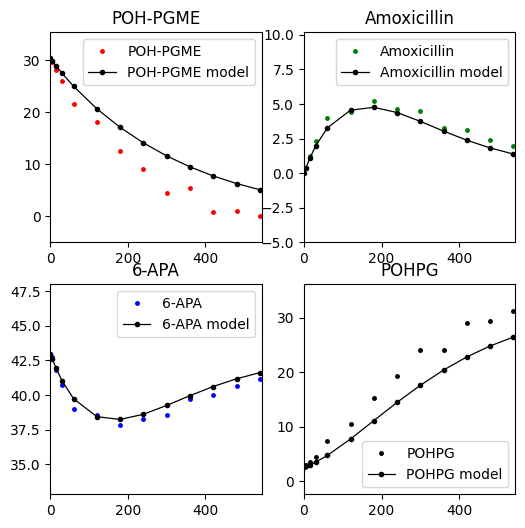

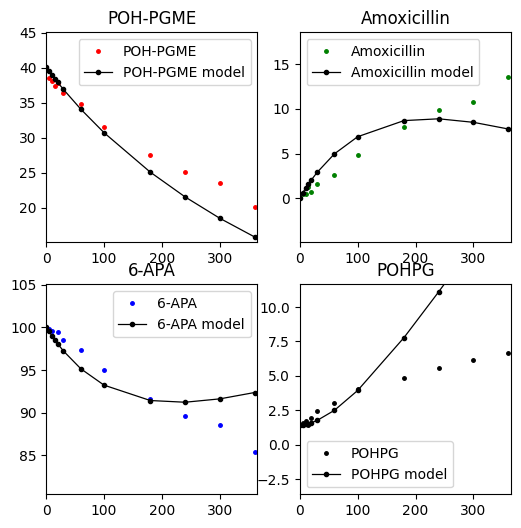

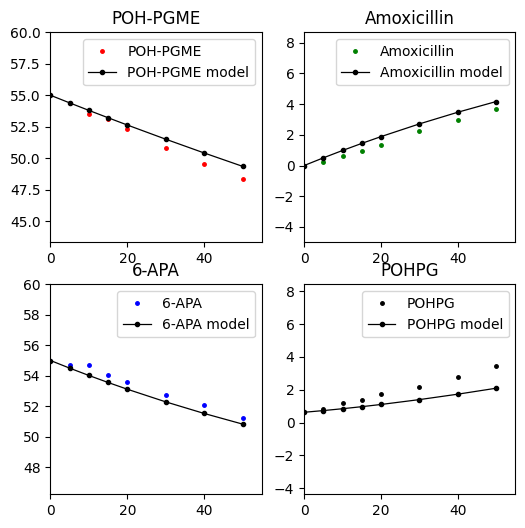

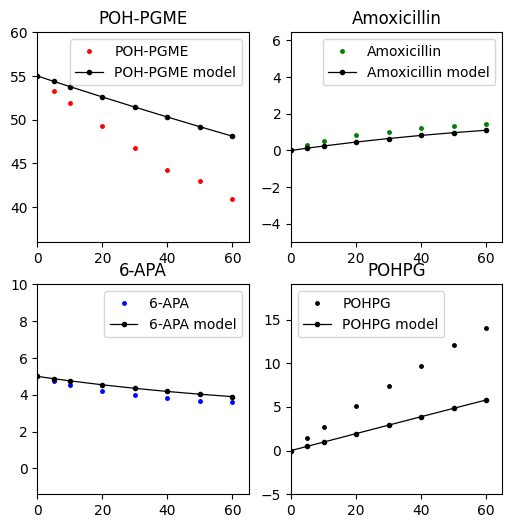

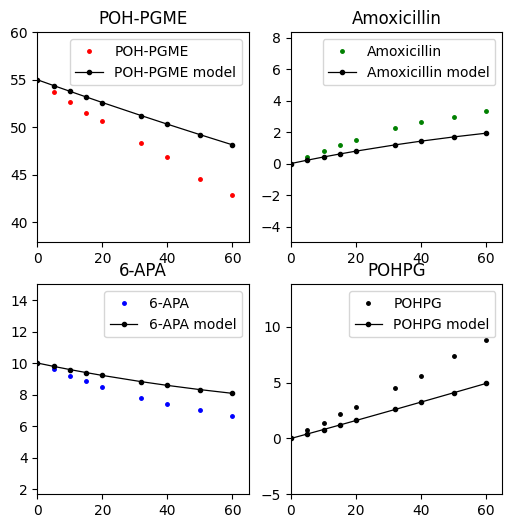

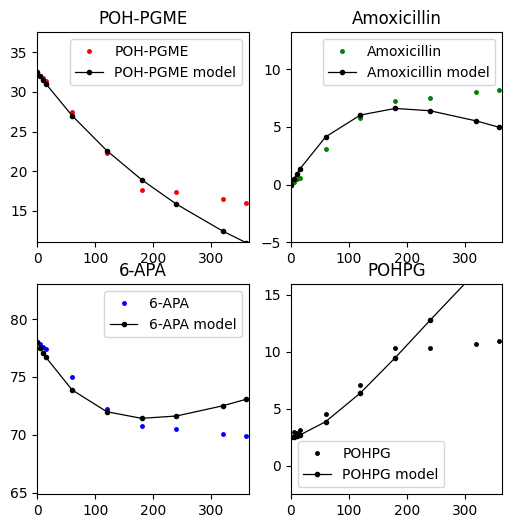

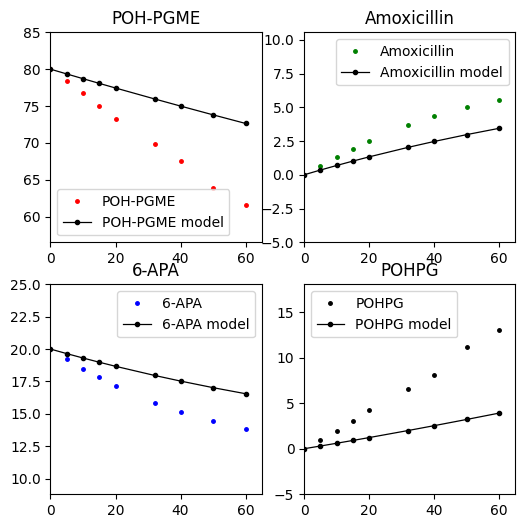

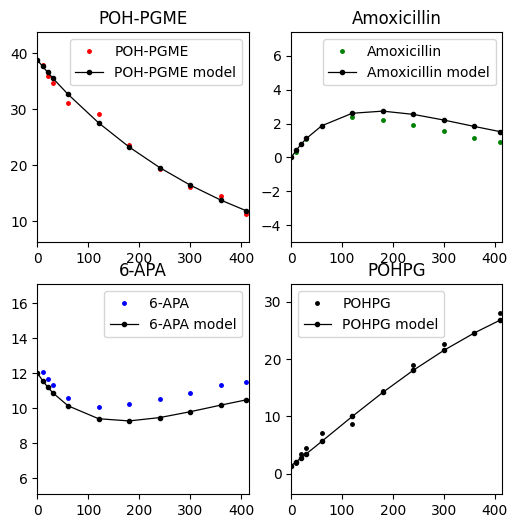

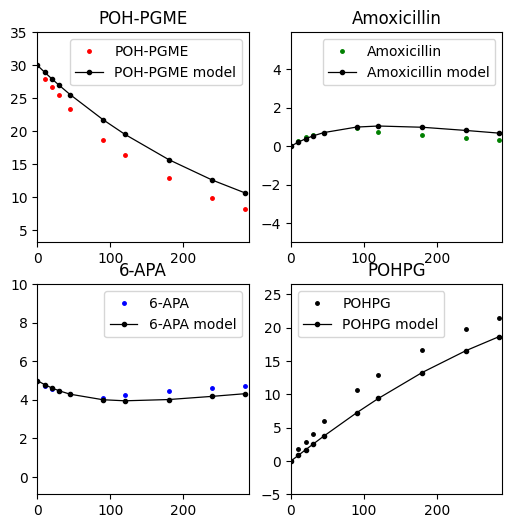

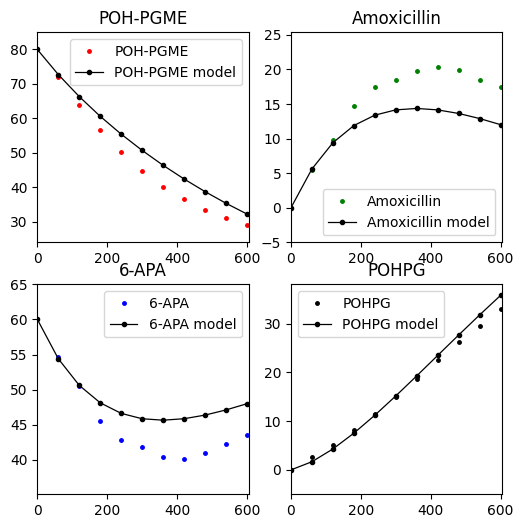

In [15]:
eval_performance(ensaios_dfs[3].loc['50000_luci_mean',:],plot=True)

# Parâmetros estimados c/ 100000

In [16]:
def import_dfs():
    # Path to the folder containing CSV files
    folder_path = './results_mcmc'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '100000*mean.csv'))
    # Initialize an empty list to hold dataframes
    data_frames = []
    # Read the first CSV file to establish the schema
    schema = ['kcat1',
        'kcat2',
        'Km1',
        'Km2',  
        'Tmax', 
        'Ken',  
        'kAB',  
        'kAN',  
        'kAOH', 
        'kNH']

    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  
        
        df = df[schema]  # Reorder columns to match the schema
        data_frames.append(df)
    
    csv_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]
    print(csv_files)
    return data_frames,csv_files 

data_frames_chains,file_list = import_dfs()

['100000_article_mean', '100000_bestnm_mean', '100000_lucas_mean', '100000_luci_mean']


## Guardar ensaios em um dataframe

In [17]:
ensaios_dfs = []
for i in range(data_frames_chains[0].shape[0]):
    ensaios_dfs.append(pd.DataFrame(data=np.zeros((len(data_frames_chains),data_frames_chains[0].shape[1])),index=file_list,columns=labels))

for idx,df in enumerate(data_frames_chains):
    for row in df.index:
        ensaios_dfs[row].loc[file_list[idx],:] = df.iloc[row]

## Visualização da performance

In [18]:
best = find_best()

<Axes: >

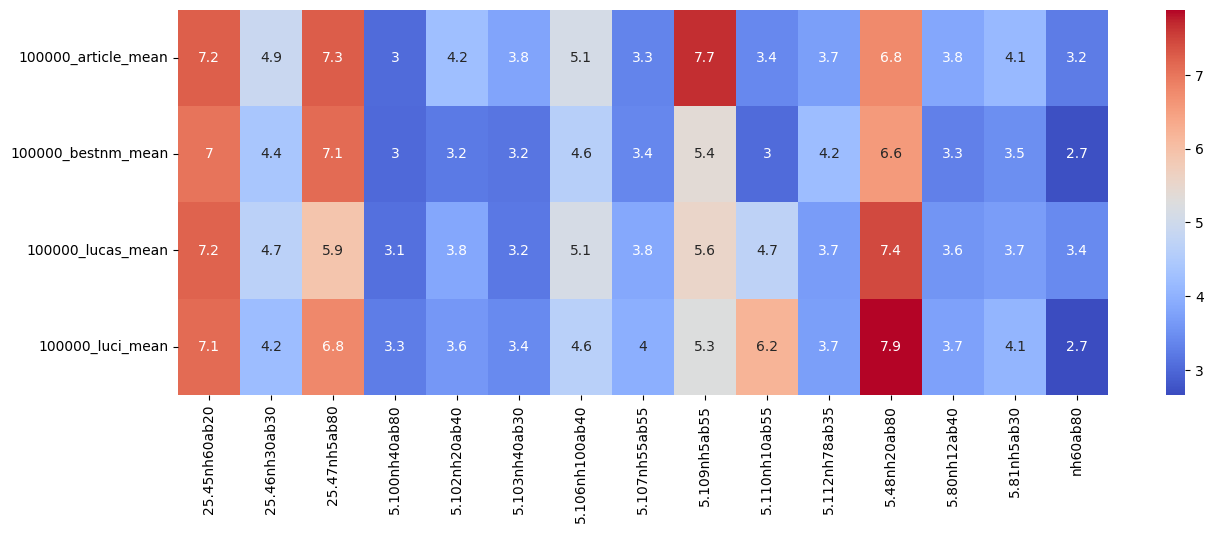

In [19]:
plt.figure(figsize=(15,5))
sns.heatmap(best,annot=True, cmap='coolwarm')

Error 25.45nh60ab20: 5.697868310760354
Error 25.46nh30ab30: 3.6563649145039916
Error 25.47nh5ab80: 5.913022009349172
Error 5.100nh40ab80: 3.598297607101734
Error 5.102nh20ab40: 3.5025220073901
Error 5.103nh40ab30: 2.6345487758578705
Error 5.106nh100ab40: 3.036007426967075
Error 5.107nh55ab55: 0.786459541815144
Error 5.109nh5ab55: 1.650957478441301
Error 5.110nh10ab55: 0.5533548532330257
Error 5.112nh78ab35: 2.0986846022757
Error 5.48nh20ab80: 2.2717640942724358
Error 5.80nh12ab40: 2.3864316063939537
Error 5.81nh5ab30: 0.9854551736977496
Error nh60ab80: 1.214488838831366
total error:  39.98622724089097


39.98622724089097

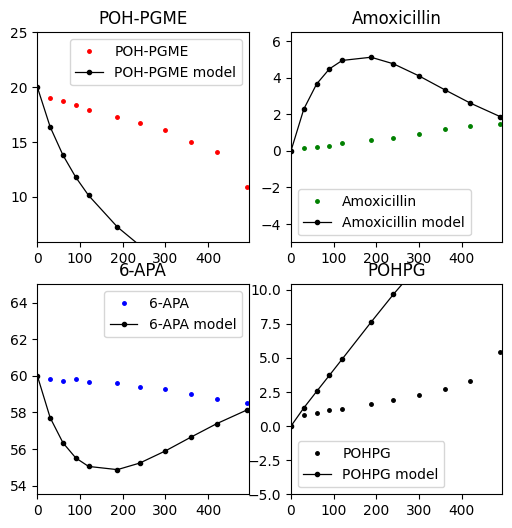

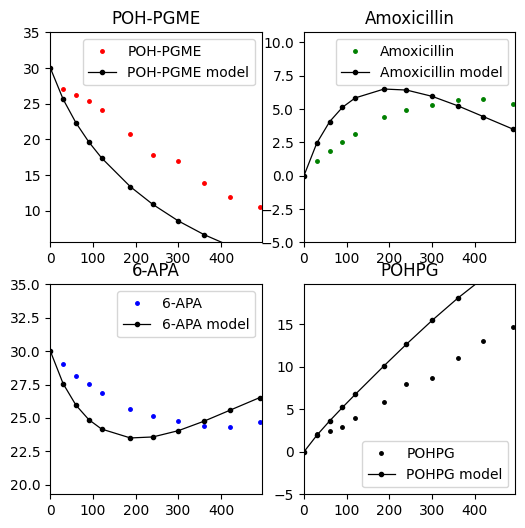

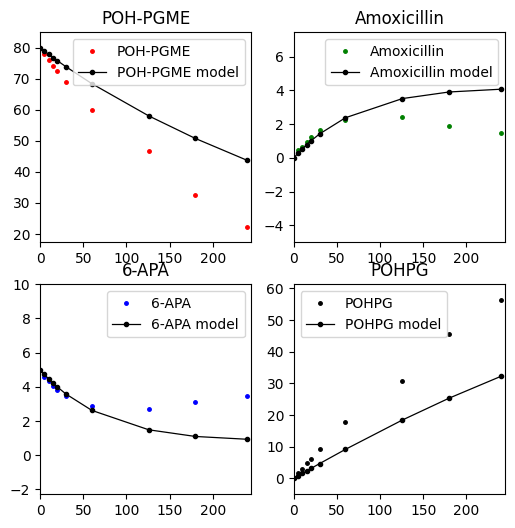

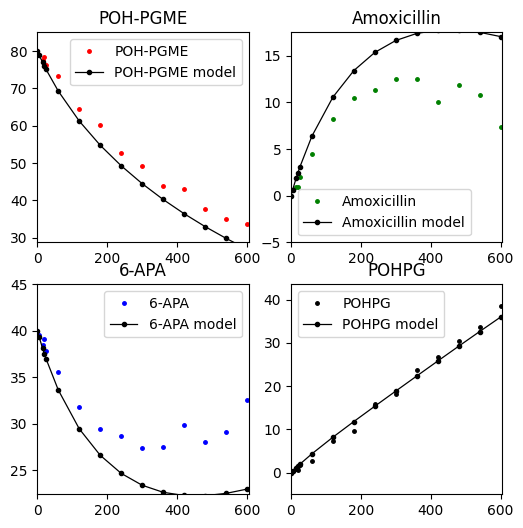

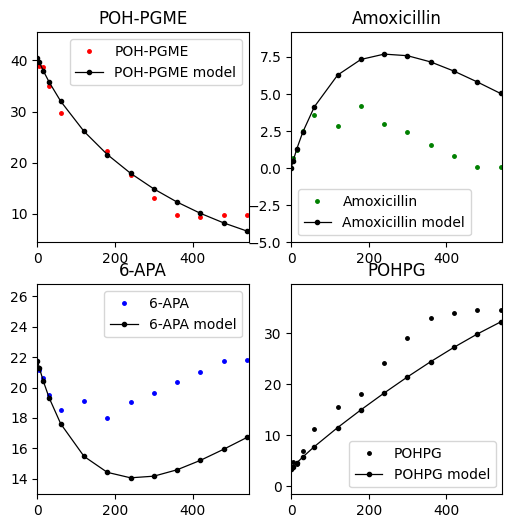

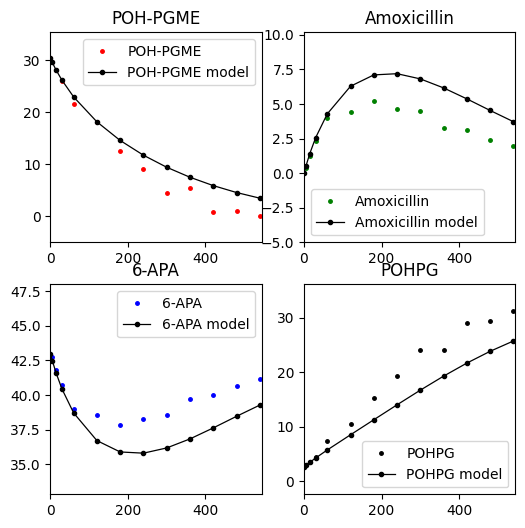

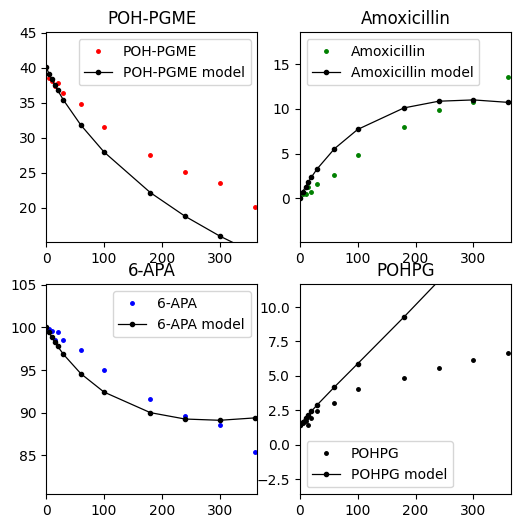

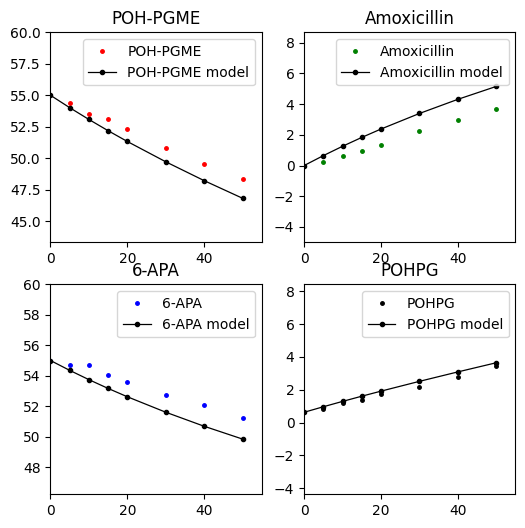

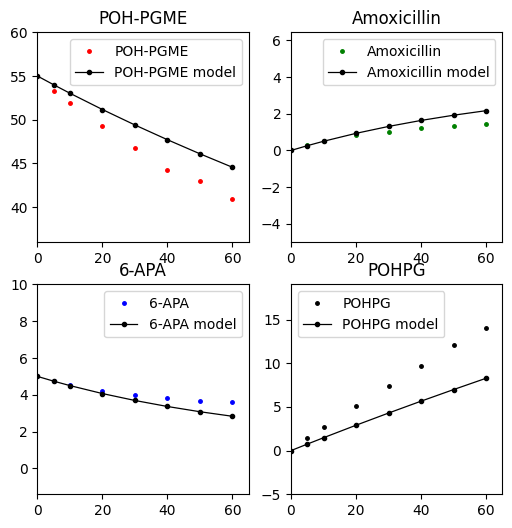

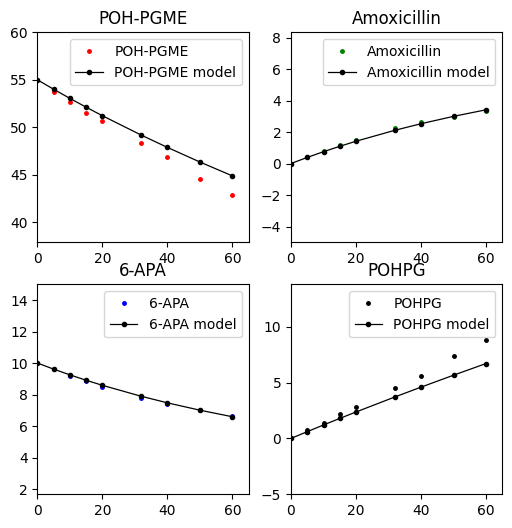

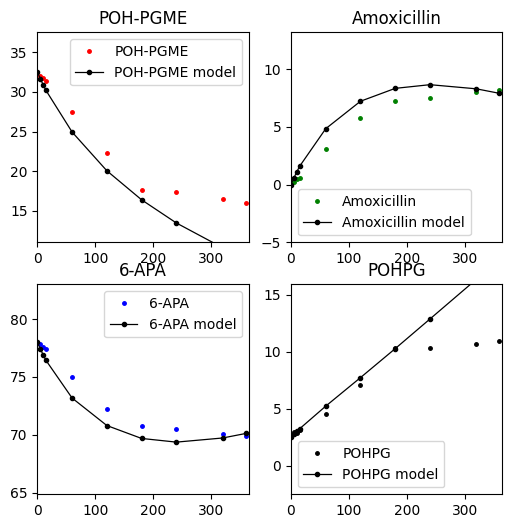

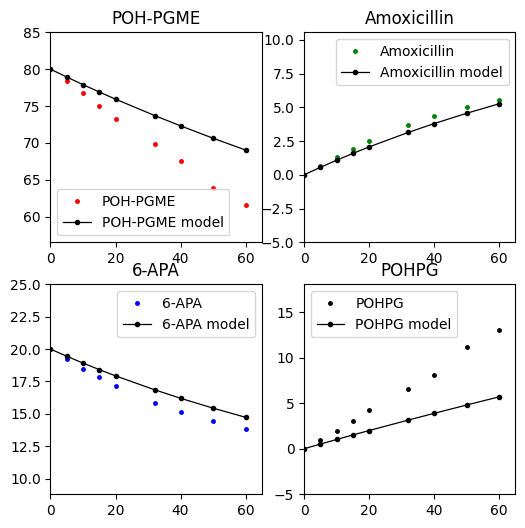

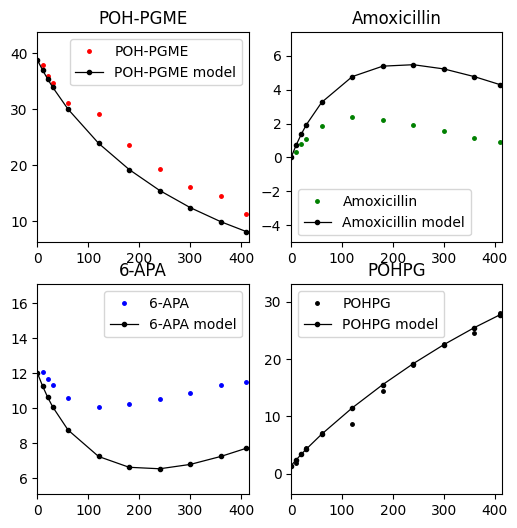

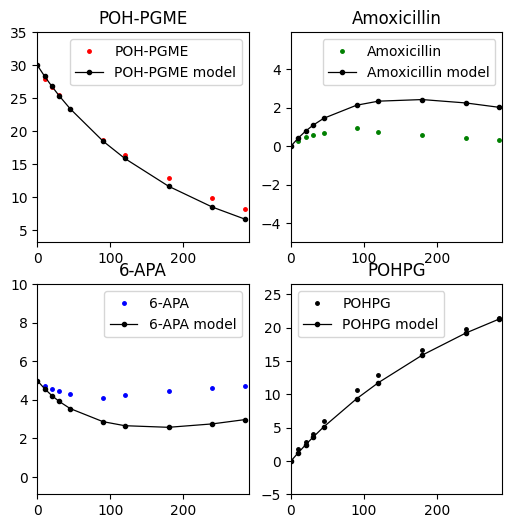

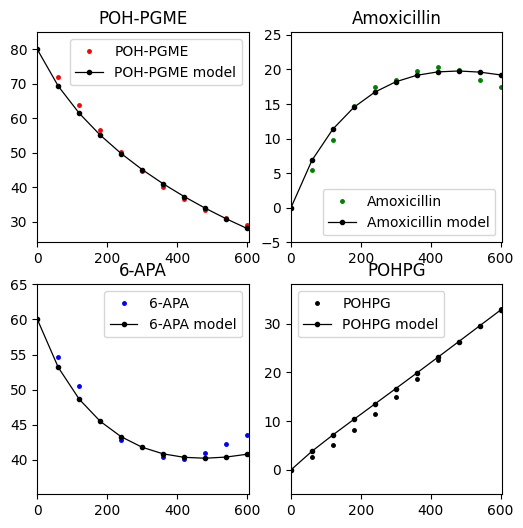

In [20]:
eval_performance(ensaios_dfs[-1].loc['100000_luci_mean',:],plot=True)

Error 25.45nh60ab20: 6.569938586036995
Error 25.46nh30ab30: 5.175362303975923
Error 25.47nh5ab80: 6.018874396875338
Error 5.100nh40ab80: 2.8594090537063463
Error 5.102nh20ab40: 2.2557767850752515
Error 5.103nh40ab30: 1.4354265218958453
Error 5.106nh100ab40: 3.3098751162198887
Error 5.107nh55ab55: 0.7059327276724987
Error 5.109nh5ab55: 1.5437431795456313
Error 5.110nh10ab55: 0.778050240032588
Error 5.112nh78ab35: 2.6876831880469076
Error 5.48nh20ab80: 2.7133736411855183
Error 5.80nh12ab40: 2.6133296035434994
Error 5.81nh5ab30: 1.2005952652365903
Error nh60ab80: 0.9190203337629564
total error:  40.786390942811785


40.786390942811785

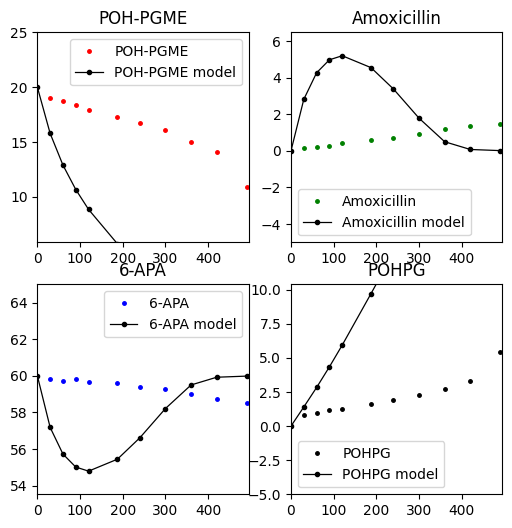

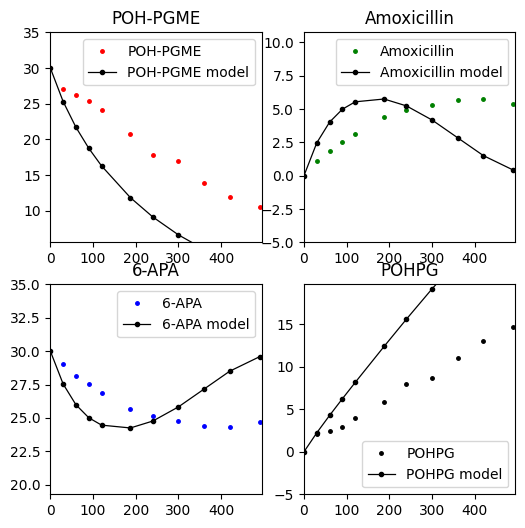

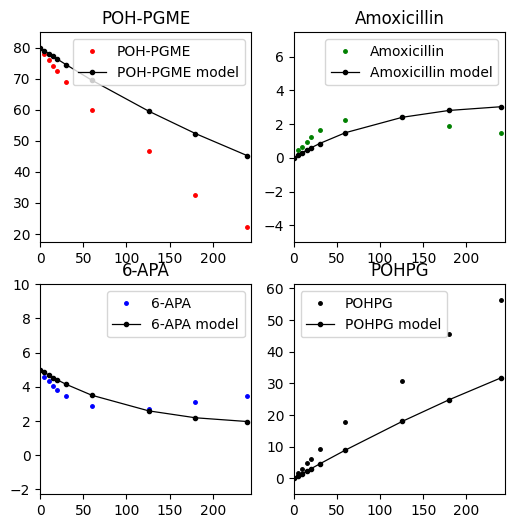

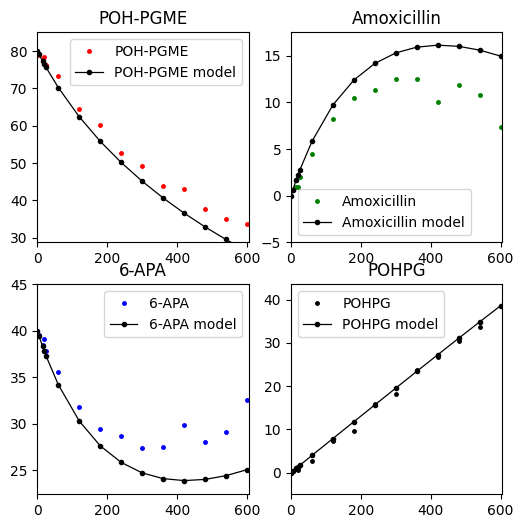

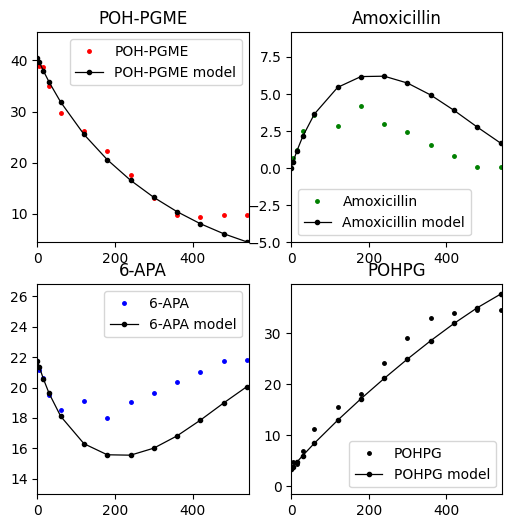

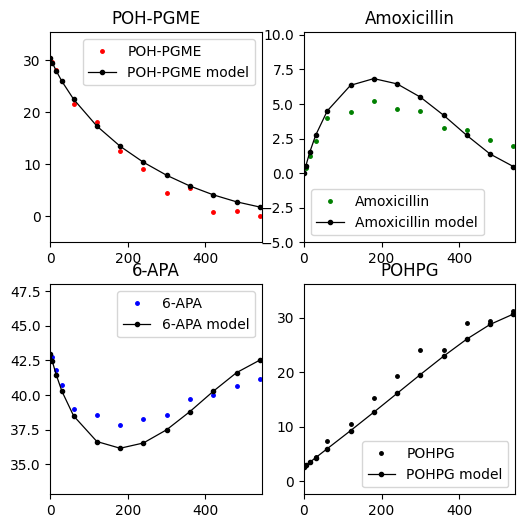

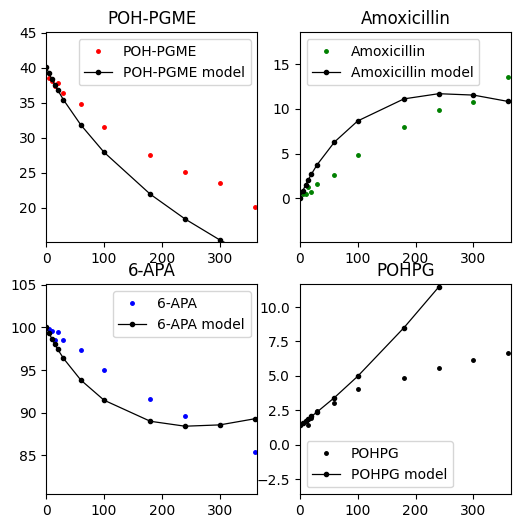

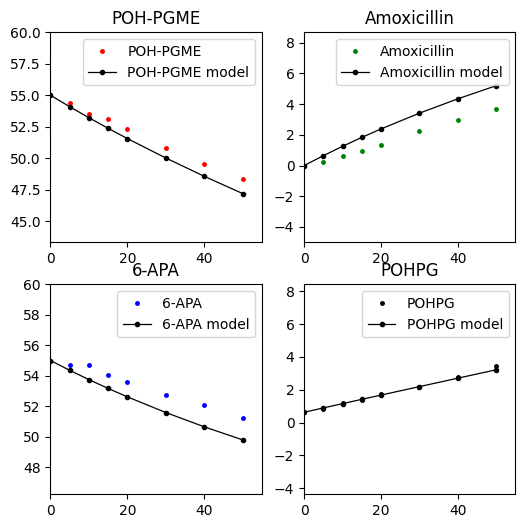

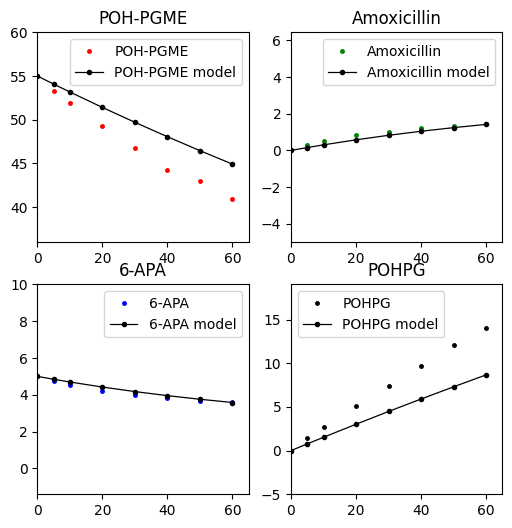

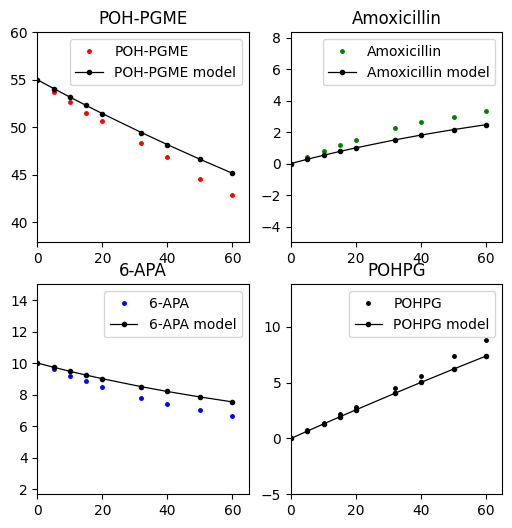

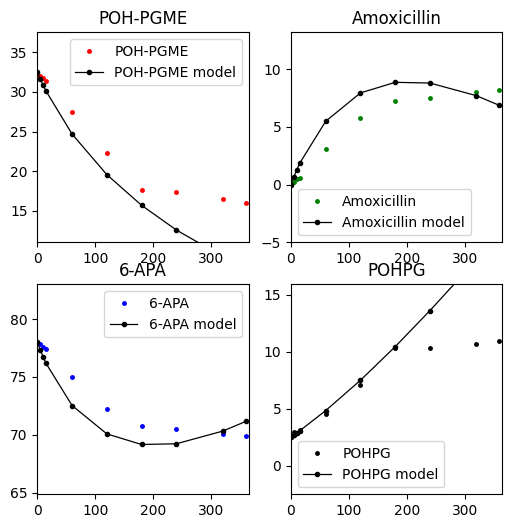

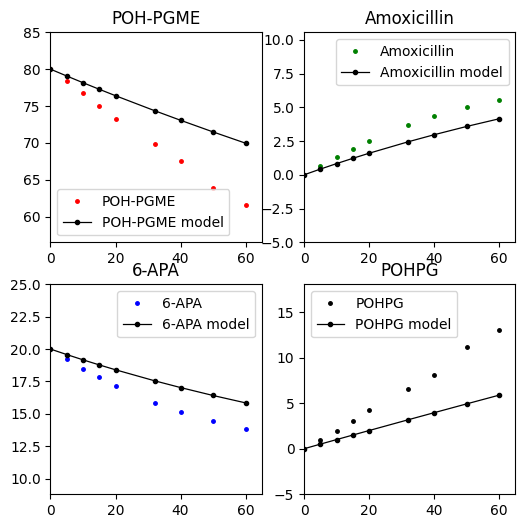

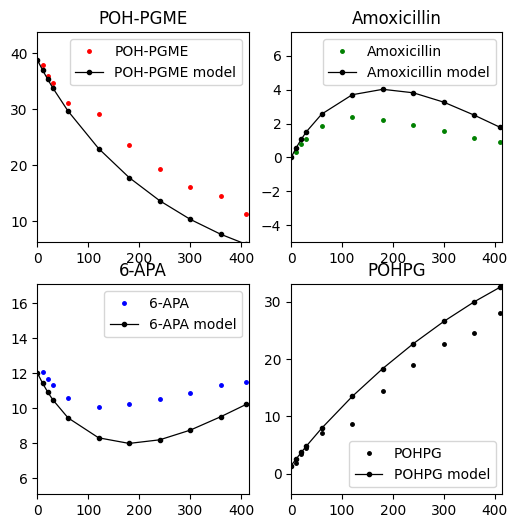

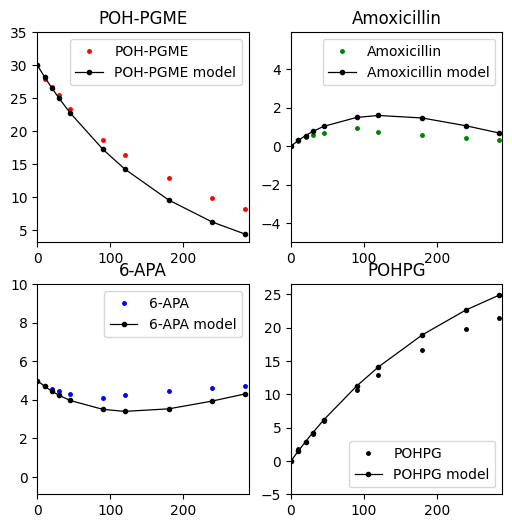

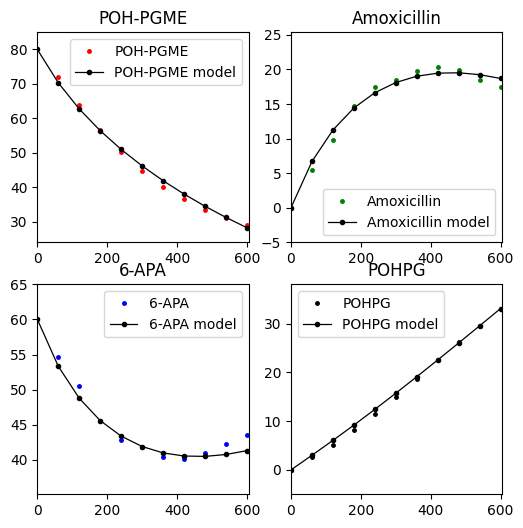

In [21]:
eval_performance(ensaios_dfs[-1].loc['100000_bestnm_mean',:],plot=True)